In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

# imgaug provides more augmentation techniques than keras
from imgaug import augmenters as aug

In [0]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth',-1)

In [0]:
# take just the name of the image
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

<Container object of 25 artists>

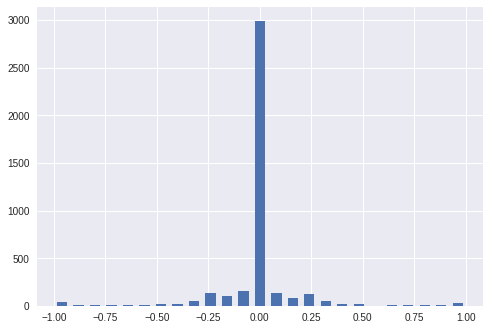

In [0]:
# plot histogram of stering angles
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
# add the value 0 (straight direction) in the center of the bns array
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)

A lot of the angles are 0. This could cause the model into predict 0 and go straight most of the time. It is useful to add an equal treshold for every bin 

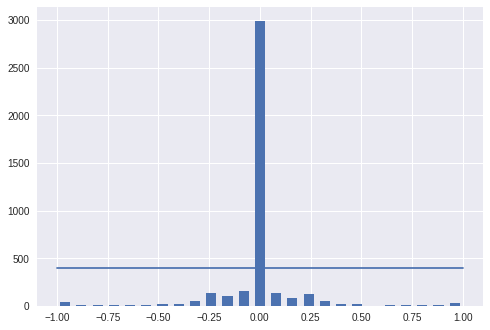

In [0]:
# if you increase the treshold the straight examples will be more numerous, thus the car will jiggle less in a straight line
treshold = 400
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

total data:  4053
removed 2590
remaining 1463


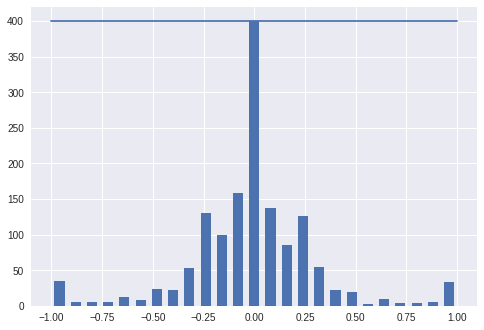

In [0]:
print('total data: ', len(data))
# samples we want to remove
remove_list = []
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
      # in the end list_ will contain all data of a particuar steering angle, 
      #and we need to cut values above the treshold.
      # the array is ordered, so we cannot cut the last elements, since we would lose
      # infos about the last part of the path
  list_ = shuffle(list_)
  list_ = list_[treshold:]
  remove_list.extend(list_)
    
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist , _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (treshold, treshold))

In [0]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    #remove the path, as above
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_path, steerings
# the X and y of our model
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training samples: {len(X_train)}\nValid_samples: {len(X_val)}')

Training samples: 1170
Valid_samples: 293


Text(0.5,1,'Training set')

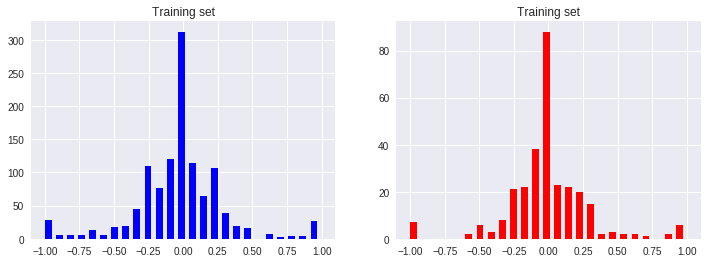

In [0]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Training set')
ax[1].hist(y_val, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Training set')

Text(0.5,1,'Zoomed image')

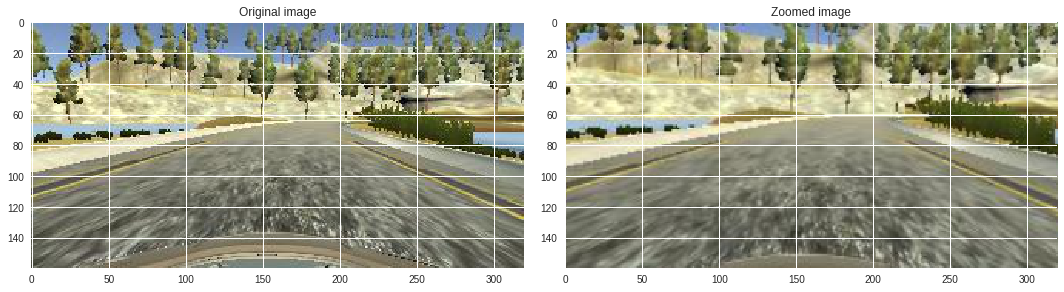

In [0]:
# augmentation techniques
def zoom(image):
  # we can zoom up to 30% of each image
  zoom = aug.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image =zoom(original_image)

fig, ax = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original image')
ax[1].imshow(zoomed_image)
ax[1].set_title('Zoomed image')

Text(0.5,1,'Panned Image')

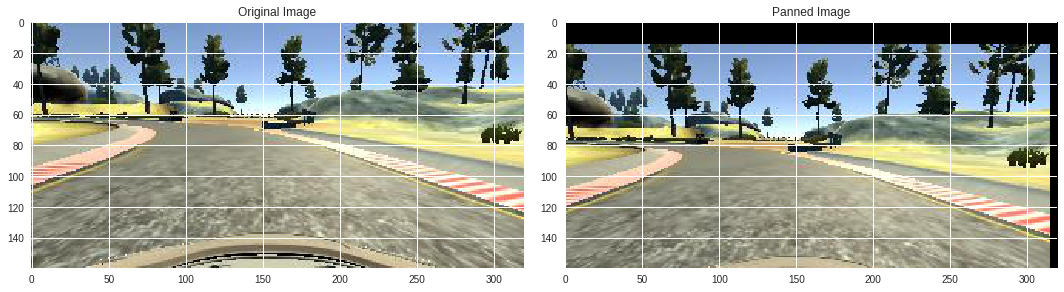

In [0]:
def pan(image):
  pan = aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5,1,'Brightness altered image ')

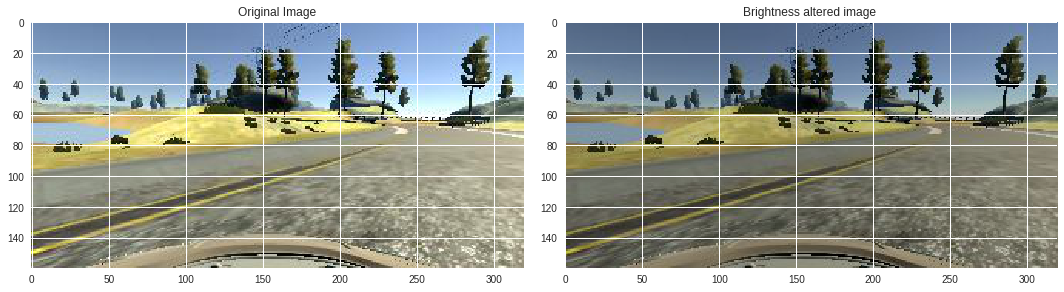

In [0]:
def img_random_brightness(image):
  # darker images work better (from experience)
    brightness = aug.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5,1,'Flipped Image - Steering Angle:0.1614014')

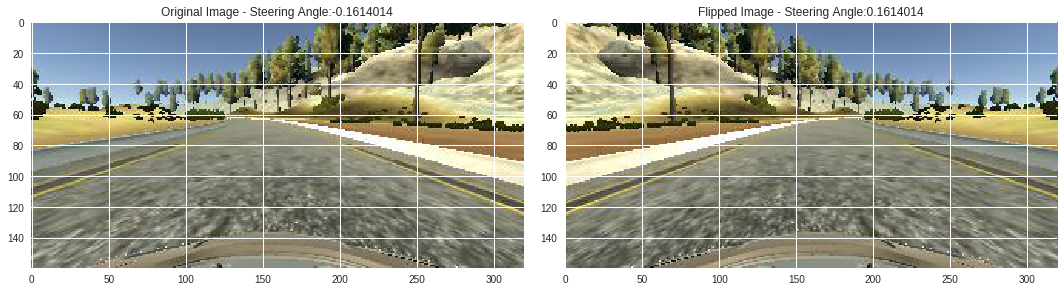

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
# we augment the images in order to have a larger and more general training set
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  # 50% the image will have  a random augmentation
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle     

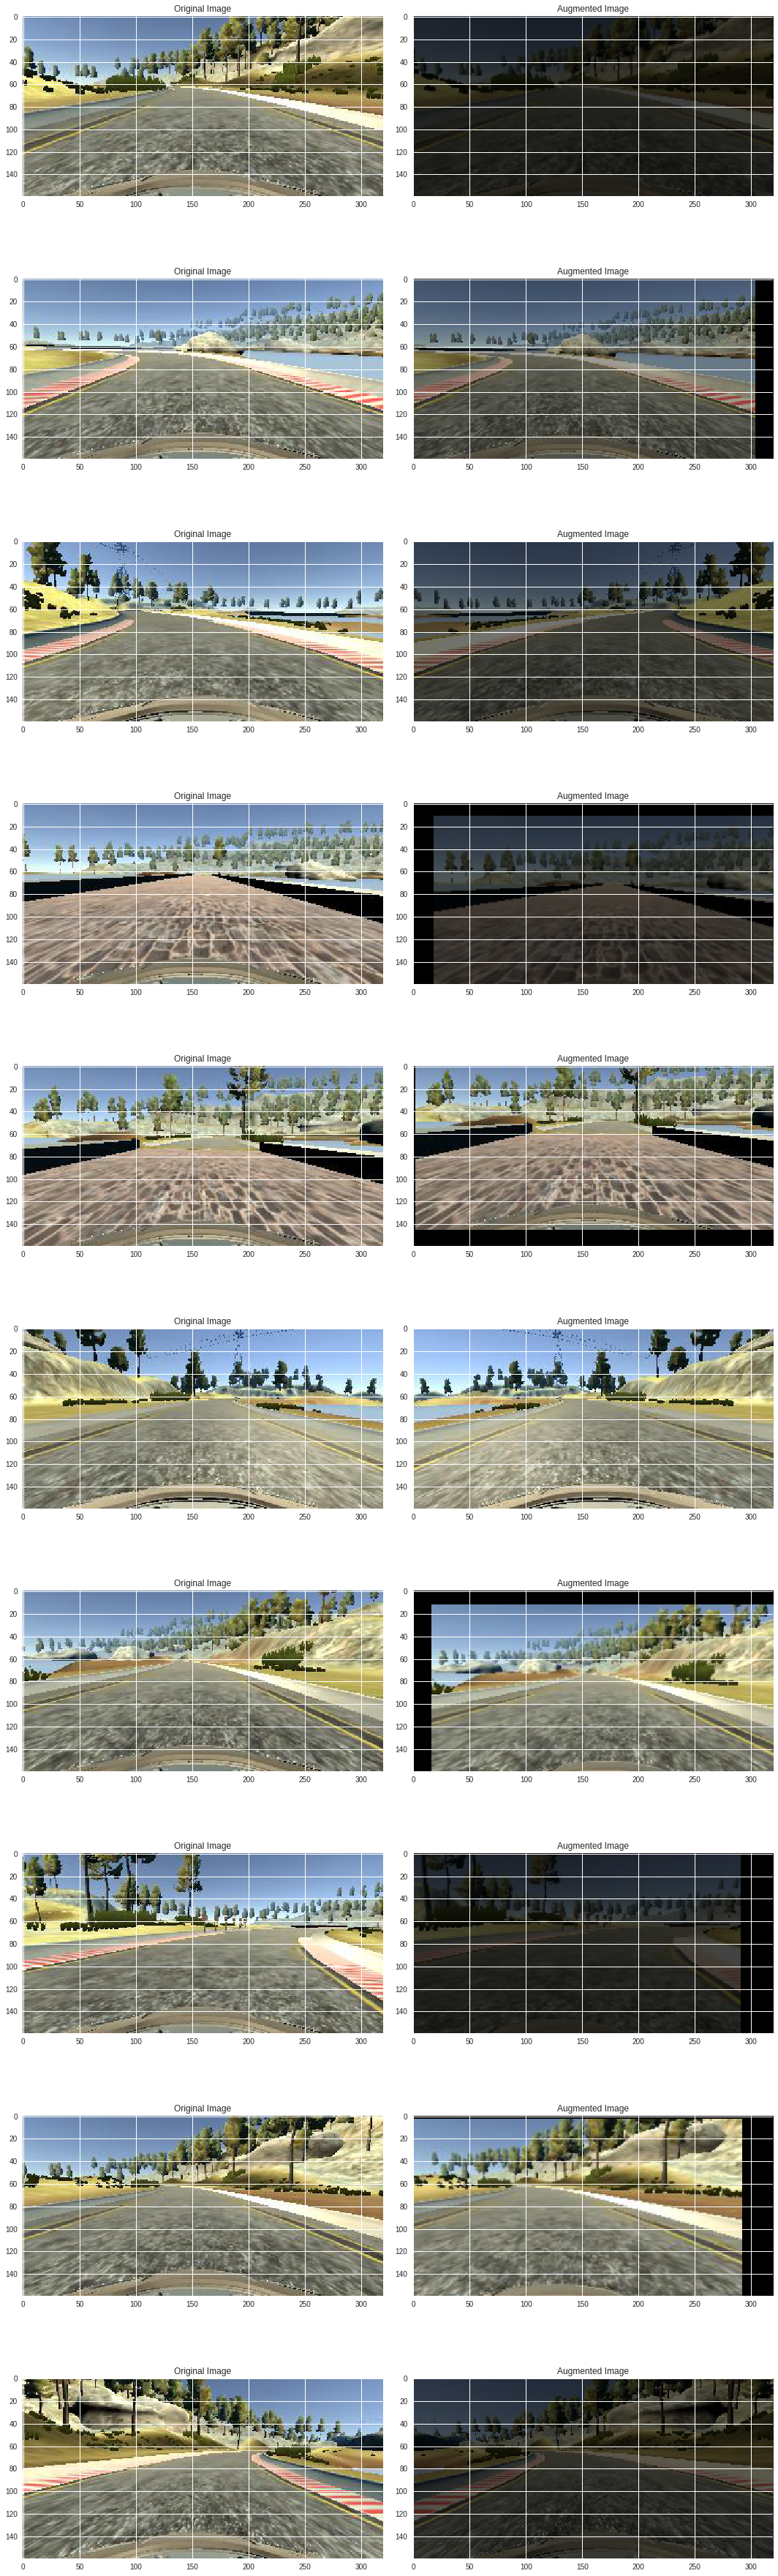

In [0]:
ncol = 2
nrow = 10
fig, ax = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  
  ax[i][0].imshow(original_image)
  ax[i][0].set_title('Original Image')

  ax[i][1].imshow(augmented_image)
  ax[i][1].set_title('Augmented Image')
  

In [0]:
def img_preprocess(img):

  # crop useless bottom and top of img
  img = img[60:135,:,:]
  #YUV is the suggested color palette from Nvidia. Y = luminosity, UV = image chromium
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #reduce noise and smoothing img
  img = cv2.GaussianBlur(img, (3,3), 0)
  # resize image
  img = cv2.resize(img, (200,66))
  #normalize
  img = img/255
  return img

Text(0.5,1,'Preprocessed Image')

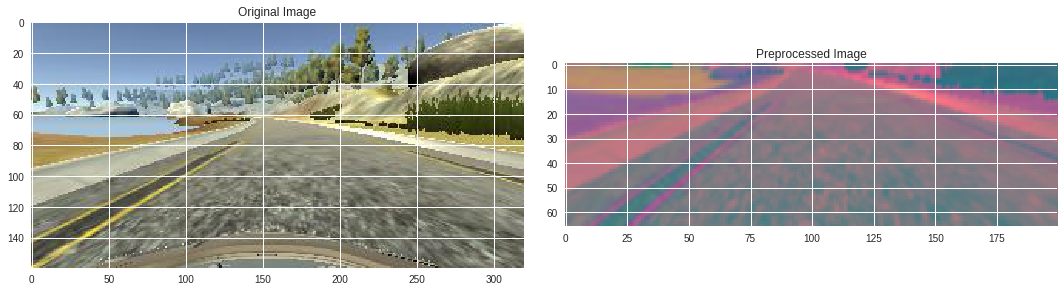

In [0]:
# read random img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, ax = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(preprocessed_image)
ax[1].set_title('Preprocessed Image')

In [0]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_val= np.array(list(map(img_preprocess, X_val)))

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
      yield(np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5,1,'Validation Image')

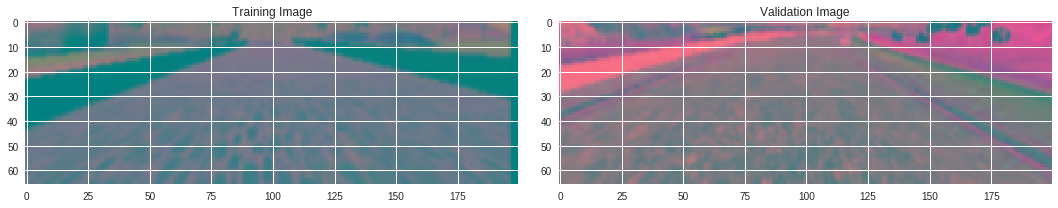

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train,1,1))
X_val_gen, y_val_gen = next(batch_generator(X_val, y_val,1,0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(X_val_gen[0])
axs[1].set_title('Validation Image')

In [0]:
# this Nvidia model is proven to be effective for behavioural cloning
# since we are augmenting data there is way laess risk of overfitting, so the dropouts are removed
def nvidia_model():
  model = Sequential()
  #elu it's like leaky relu but exponenential
  model.add(Convolution2D(24,5,5,subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36,5,5,subsample=(2,2), activation='elu'))
  model.add(Convolution2D(48,5,5,subsample=(2,2), activation='elu'))
  model.add(Convolution2D(64,3,3, activation='elu'))
  model.add(Convolution2D(64,3,3, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model
 

In [0]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)              0         
__________

In [0]:
# the generator generates 100 images per step
#steps per epoch = augment 100 images 300 times == 30000

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_val, y_val, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


Epoch 1/10
300/300 [==============================] - 170s 566ms/step - loss: 0.0801 - val_loss: 0.0620
Epoch 2/10
300/300 [==============================] - 168s 560ms/step - loss: 0.0621 - val_loss: 0.0584
Epoch 3/10
300/300 [==============================] - 168s 560ms/step - loss: 0.0470 - val_loss: 0.0531
Epoch 4/10
300/300 [==============================] - 168s 560ms/step - loss: 0.0723 - val_loss: 0.0705
Epoch 5/10
300/300 [==============================] - 168s 560ms/step - loss: 0.0438 - val_loss: 0.0551
Epoch 6/10
300/300 [==============================] - 169s 563ms/step - loss: 0.0362 - val_loss: 0.0856
Epoch 7/10
300/300 [==============================] - 167s 558ms/step - loss: 0.0492 - val_loss: 0.0841
Epoch 8/10
300/300 [==============================] - 168s 560ms/step - loss: 0.0589 - val_loss: 0.0631
Epoch 9/10
300/300 [==============================] - 168s 561ms/step - loss: 0.0488 - val_loss: 0.0866
Epoch 10/10
300/300 [==============================] - 168s 561m

Text(0.5,0,'epochs')

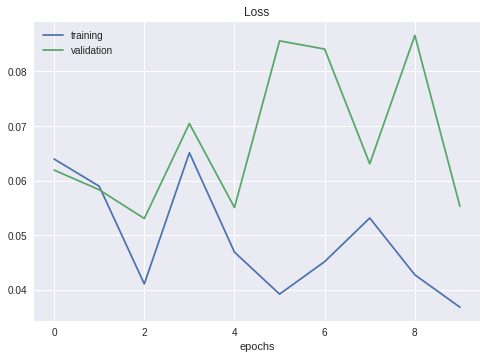

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epochs')

In [0]:
# we will use a model for Nvidia, proven to be effective for behavioural cloning
def nvidia_model_bn():
  model = Sequential()
  #elu it's like leaky relu but exponenential
  model.add(Convolution2D(24,5,5,subsample=(2,2), input_shape=(66,200,3)))
  model.add(BatchNormalization())
  model.add(Activation("elu"))
  model.add(Convolution2D(36,5,5,subsample=(2,2)))
  model.add(BatchNormalization())
  model.add(Activation("elu"))
  model.add(Convolution2D(48,5,5,subsample=(2,2)))
  model.add(BatchNormalization())
  model.add(Activation("elu"))
  model.add(Convolution2D(64,3,3))
  model.add(BatchNormalization())
  model.add(Activation("elu"))
  model.add(Convolution2D(64,3,3))
  model.add(BatchNormalization())
  model.add(Activation("elu"))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
model = nvidia_model_bn()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 98, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
__________

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_val, y_val, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


Epoch 1/10
300/300 [==============================] - 265s 884ms/step - loss: 0.3887 - val_loss: 0.0922
Epoch 2/10
300/300 [==============================] - 263s 876ms/step - loss: 0.0985 - val_loss: 0.1394
Epoch 3/10
300/300 [==============================] - 264s 879ms/step - loss: 0.1695 - val_loss: 0.1260
Epoch 4/10
300/300 [==============================] - 263s 878ms/step - loss: 0.1438 - val_loss: 0.1876
Epoch 5/10
300/300 [==============================] - 263s 878ms/step - loss: 0.0516 - val_loss: 0.0587
Epoch 6/10
300/300 [==============================] - 265s 883ms/step - loss: 0.0507 - val_loss: 0.0778
Epoch 7/10
300/300 [==============================] - 264s 879ms/step - loss: 0.0463 - val_loss: 0.0774
Epoch 8/10
300/300 [==============================] - 263s 877ms/step - loss: 0.0424 - val_loss: 0.0845
Epoch 9/10
300/300 [==============================] - 264s 879ms/step - loss: 0.0439 - val_loss: 0.0566
Epoch 10/10
300/300 [==============================] - 265s 883m

Text(0.5,0,'epochs')

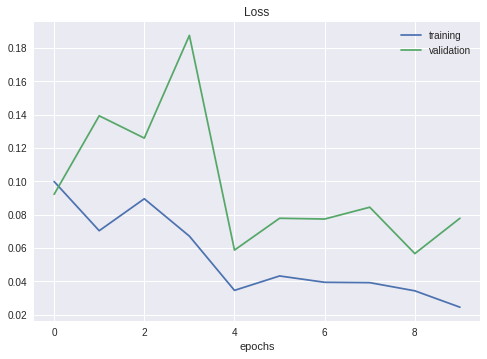

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epochs')

In [0]:
model.save('model_nvidia_aug.h5')

In [0]:
# download model
from google.colab import files
files.download('model_nvidia_aug.h5')